In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
male_df = male_df.query('age<100')

In [7]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)


In [8]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [9]:
# choose a model for decoder
clf = PLSRegression(n_components=5)
cv = LeaveOneOut()
#number of iterations for shuffle
it=1000

In [10]:
format_plots()

In [11]:
#prepare data
data=m_norm.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [12]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.788909643047699


In [13]:
res_age = y_age.flatten()-y_pred.flatten()
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

7.181264357879799
7.980724521625045


In [14]:
from scipy.stats import pearsonr
print(pearsonr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.8883063031763184, pvalue=7.799322616864723e-244)


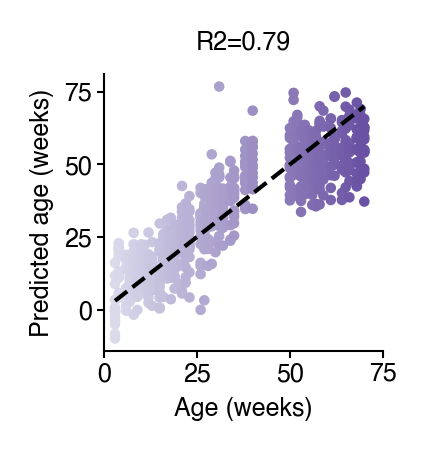

In [15]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[0, 25, 50, 75], xticks=[0, 25, 50, 75], xlabel="Age (weeks)", ylabel="Predicted age (weeks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [16]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'decoder_true_vs_predicted_long_resampled.pdf', bbox_inches='tight')

In [17]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [42:07<00:00,  2.53s/it]


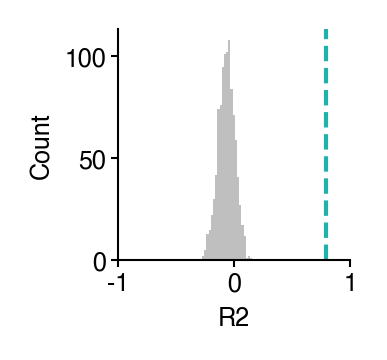

In [18]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#20B2AA', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_age_regression_shuf_resampled.pdf', bbox_inches='tight')

In [19]:
## leave one age out

In [20]:
#prepare data
data=m_norm.copy()
y_pred=[]
y_age=[]
for age in data.index.get_level_values('age').unique():
    test = data[data.index.get_level_values('age')==age]
    x_test = test.to_numpy()
    y_test = test.index.get_level_values('age')
    
    train = data[data.index.get_level_values('age')!=age]
    x_train = train.to_numpy()
    y_train = train.index.get_level_values('age')
    
    clf.fit(x_train, y_train)
    pred =clf.predict(x_test)
    
    y_age.extend(y_test)
    y_pred.extend(pred)

In [21]:
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.7717346955355776


In [22]:
from scipy.stats import pearsonr
print(pearsonr(y_age, np.array(y_pred).flatten()))

PearsonRResult(statistic=0.8787492972391675, pvalue=7.175024056658035e-232)


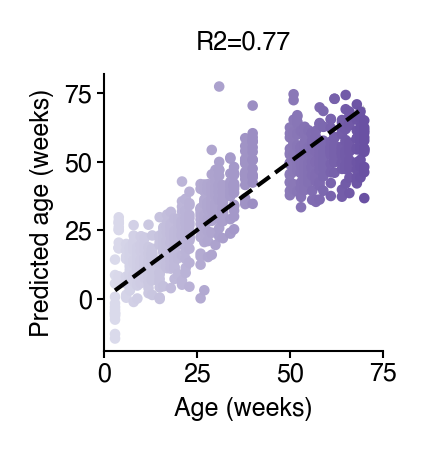

In [23]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[0, 25, 50, 75], xticks=[0, 25, 50, 75], xlabel="Age (weeks)", ylabel="Predicted age (weeks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [24]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'decoder_true_vs_predicted_long_leave_age_out_resampled.pdf', bbox_inches='tight')